
### OVERVIEW
The starting point is this interesting dataset about flight connections
https://openflights.org/data.html
in particular, we'll focus on the "route" part which lists most of the flight routes that were active in 2014.
One first goal of the project is to study this infrastructure network and its topology. We want to understand what are the important/central airports and important/central connections. Then, we want to study how "robust" the network is when we remove some of its nodes, or some of its edges.

### METHODS
We start by extracting some basic data summaries from the countries data (then move to the airports data), for example:
- the number of nodes and edges
- rank the nodes according to their in-degree and out-degree
- rank the nodes according to their eigenvector centrality
- rank the nodes and the edges according to their betweenness centrality
- find the "coreness" of the nodes (e.g. 1-core, 2-core, 3-core, etc...)
- highlight and motivate any differences between results, and interpret based on the context and geographical locations of countries

#### Dependencies

In [1]:
import os
import sys
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
from time import time
import seaborn as sns
import warnings
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from IPython.display import display, HTML
from sklearn.utils import shuffle
from random import randint
import pickle
from sklearn.neighbors import DistanceMetric

np.seterr('raise')
# warnings.filterwarnings('ignore')

def plot_heatmap(df, cmap='Reds', ax=None):
    labels_y = df.columns.tolist()
    labels_x = df.index.tolist()

    if labels_y == labels_x:
        sns.heatmap(df, annot=True, fmt=".2f", cmap=cmap, yticklabels=labels_x,
                    xticklabels=labels_y, label='small', ax = ax, mask=np.triu(df, k=0))
    else: 
        sns.heatmap(df, annot=True, fmt=".2f", cmap=cmap, yticklabels=labels_x,
                    xticklabels=labels_y, label='small', ax = ax)

#### Loading Airports Data

<table>
		<tr>
		  <td class="head">Airport ID</td>
		  <td class="data">Unique OpenFlights identifier for this airport.
		</td></tr>
		<tr>
		  <td class="head">Name</td>
		  <td class="data">Name of airport.  May or may not contain the <b>City</b> name.</td>
		</tr>
		<tr>
		  <td class="head">City</td>
		  <td class="data">Main city served by airport.  May be spelled differently from <b>Name</b>.</td>
		</tr>
		<tr>
		  <td class="head">Country</td>
		  <td class="data">Country or territory where airport is located.  See <a href="#country">Countries</a> to cross-reference to ISO 3166-1 codes.
		  </td>
		</tr>
		<tr>
		  <td class="head">IATA</td>
		  <td class="data">3-letter IATA code. (Of the airpot)  Null if not assigned/unknown.</td>
		</tr>
		<tr>
		  <td class="head">ICAO</td>
		  <td class="data">4-letter ICAO code. (Of the airpot)<br>
		    Null if not assigned.</td>
		</tr>
		<tr>
		  <td class="head">Latitude</td>
		  <td class="data">Decimal degrees, usually to six significant digits.  Negative is South, positive is North.</td>
		</tr>
		<tr>
		  <td class="head">Longitude</td>
		  <td class="data">Decimal degrees, usually to six significant digits.  Negative is West, positive is East.</td>
		</tr>
		<tr>
		  <td class="head">Altitude</td>
		  <td class="data">In feet.</td>
		</tr>
		<tr>
		  <td class="head">Timezone</td>
		  <td class="data">Hours offset from UTC.  Fractional hours are expressed as decimals, eg. India is 5.5.</td>
		</tr>
		<tr>
		  <td class="head">DST</td>
		  <td class="data">Daylight savings time.  One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). <i>See also: <a target="_blank" href="help/time.html">Help: Time</a></i><a target="_blank" href="help/time.html">
		</a></td></tr>
		<tr>
		  <td class="head">Tz database time zone</td>
		  <td class="data">Timezone in <a href="http://en.wikipedia.org/wiki/Tz_database">"tz" (Olson) format</a>, eg. "America/Los_Angeles".
		</td></tr>
		<tr>
		  <td class="head">Type</td>
		  <td class="data">Type of the airport.  Value "airport" for air terminals, "station" for train stations, "port" for
		  ferry terminals and "unknown" if not known.  <i>In airports.csv, only type=airport is included.</i>
		</td></tr>
		<tr>
		  <td class="head">Source</td>
		  <td class="data">Source of this data.  "OurAirports" for data sourced from <a href="http://ourairports.com/data/">OurAirports</a>, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions.  <i>In airports.csv, only source=OurAirports is included.</i>
		</td></tr>
	      
</table>

#### Routes Data

<table>
    <tr>
      <td class="head">Airline</td>
      <td class="data">2-letter (IATA) or 3-letter (ICAO) code of the airline.
    </td></tr>
    <tr>
      <td class="head">Airline ID</td>
      <td class="data">Unique OpenFlights identifier for airline (see <a href="#airline">Airline</a>).
    </td></tr>
    <tr>
      <td class="head">Source airport</td>
      <td class="data">3-letter (IATA) or 4-letter (ICAO) code of the source airport.<br>
    </td></tr>
    <tr>
      <td class="head">Source airport ID</td>
      <td class="data">Unique OpenFlights identifier for source airport (see <a href="#airport">Airport</a>)
    </td></tr>
    <tr>
      <td class="head">Destination airport</td>
      <td class="data">3-letter (IATA) or 4-letter (ICAO) code of the destination airport.<br>
    </td></tr>
    <tr>
      <td class="head">Destination airport ID</td>
      <td class="data">Unique OpenFlights identifier for destination airport (see <a href="#airport">Airport</a>)
    </td></tr>
    <tr>
      <td class="head">Codeshare</td>
      <td class="data">"Y" if this flight is a codeshare (that is, not operated by <i>Airline</i>, but another carrier), empty otherwise.</td>
    </tr>
    <tr>
      <td class="head">Stops</td>
      <td class="data">Number of stops on this flight ("0" for direct)</td>
    </tr>
    <tr>
      <td class="head">Equipment</td>
      <td class="data">3-letter codes for plane type(s) generally used on this flight, separated by spaces</td>
    </tr>
</table>

### Initial Data Processing

In [2]:
def import_airports_data():
    df = pd.read_csv('./datasets/airports.dat',header=None)
    df.columns = ['airport_id','name', 'city', 'country','IATA','ICAO','latitude','longitude','altitude','timezone','DST','tz','type','source']
    df = df[['name','city','country','IATA','ICAO','latitude','longitude']]
    
    # Additional Airports Data
    # https://github.com/mwgg/Airports/blob/master/airports.json

    additional_airports = pd.read_json('./datasets/additional_airports.json').T
    additional_airports = additional_airports[additional_airports['iata'] != '']
    additional_airports = additional_airports.reset_index()
    additional_airports = additional_airports[['name','city','country','iata','icao','lat','lon']]
    additional_airports.columns = ['name','city','country','IATA','ICAO','latitude','longitude']
    
    df = df.append(additional_airports)
    df = df[~df['name'].str.strip().duplicated()]
    df = df[~df['IATA'].str.strip().duplicated()]
    df = df.reset_index().drop(columns='index')
    
    return df 

def import_routes_data():
    # Note all Source / Destination airports are IATA codes
    df = pd.read_csv('./datasets/routes.dat',header=None)
    df.columns = ['airline','airline_id', 'source_airport', 'source_airport_id','destination_airport','destination_airport_id','codeshare','stops','equipment']
    return df

def merge_airport_country_data(routes, airports):
    key_routes_data = routes[['source_airport','destination_airport']]
    key_airport_data = airports[['IATA','country']]
    key_airport_data = key_airport_data[key_airport_data['IATA'] != '\\N'].set_index('IATA')
    IATA_map_to_other = key_airport_data.to_dict('index')
    key_routes_data['source_country'] = key_routes_data['source_airport'].apply(lambda x: IATA_map_to_other[x]['country'] if x in IATA_map_to_other else 'missing')
    key_routes_data['destination_country'] = key_routes_data['destination_airport'].apply(lambda x: IATA_map_to_other[x]['country'] if x in IATA_map_to_other else 'missing')
    
    return key_routes_data

def create_Y_matrix(key_routes_data, airport_level = False, weighted = False):
    
    source = 'source_airport' if airport_level else 'source_country'
    destination = 'destination_airport' if airport_level else 'destination_country'
        
    if weighted:
        country_routes_data = key_routes_data[[source,destination]]
    else:
        country_routes_data = key_routes_data[[source,destination]].drop_duplicates()
        
    country_routes_data = country_routes_data[(country_routes_data[source]!='missing') & (country_routes_data[destination]!='missing')]

    all_countries_available = list(set(country_routes_data[source].unique()).union(set(country_routes_data[destination].unique())))
    idx_mapping = {country: idx for idx, country in enumerate(all_countries_available)}

    n_countries = len(all_countries_available)
    Y = np.zeros((n_countries,n_countries))

    for source, destination in country_routes_data.values:
        # Arbitrarily we set the diagonal entries to zero
        if source != destination:
            if weighted:
                Y[idx_mapping[source], idx_mapping[destination]] += 1
            else:
                Y[idx_mapping[source], idx_mapping[destination]] = 1
            # Y[idx_mapping[destination], idx_mapping[source]] = 1 # Symmetric cause the plane has to fly back


    df_country_names = pd.DataFrame(Y) 
    df_country_names.index = all_countries_available
    df_country_names.columns = all_countries_available

    return df_country_names

### Execute Data Processing Scripts and Create Networks & Useful Mappings

In [2]:
# Country Lat Lon Mapping
lat_lon_countries = pd.read_csv('./datasets/lat_lon_countries.csv')
lat_lon_countries.head()
lat_lon_mapping = {row[-1]:{'lat':row[1], 'lon':row[2]} for row in lat_lon_countries.values}

# Import Airports Data
airports = import_airports_data()
airport_IATA_to_country = {airport: country for airport, country in airports[['IATA','country']].values}

lat_lon_mapping_IATA_airport = {row[0]:{'lat':row[1], 'lon':row[2]} for row in airports[['IATA','latitude','longitude']].values}

# Import Routes Data
routes = import_routes_data()
# Get rid of tiny irrelevant routes ~ 800 / 67000
routes = routes[(routes['source_airport'].isin(airports['IATA'].values)) & (routes['destination_airport'].isin(airports['IATA'].values))]

# Construct Country / Airport Routes Matrix
key_routes_data = merge_airport_country_data(routes, airports)
country_routes_matrix = create_Y_matrix(key_routes_data)
airport_routes_matrix = create_Y_matrix(key_routes_data, airport_level = True)
airport_weighted_routes_matrix = create_Y_matrix(key_routes_data, airport_level = True, weighted = True)

# filtered airports
airports_with_routes = airports[airports['IATA'].isin(airport_routes_matrix.columns)]

# Create Graphs
Y = nx.from_numpy_matrix(country_routes_matrix.values,create_using=nx.DiGraph())
Z = nx.from_numpy_matrix(airport_routes_matrix.values,create_using=nx.DiGraph())

airport_city_mapping = airports[['IATA','city']]
airport_city_mapping

airport_country_mapping = pd.read_csv('./outputs/airport_country_mapping.csv',index_col=0)

/Users/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Plot of country routes

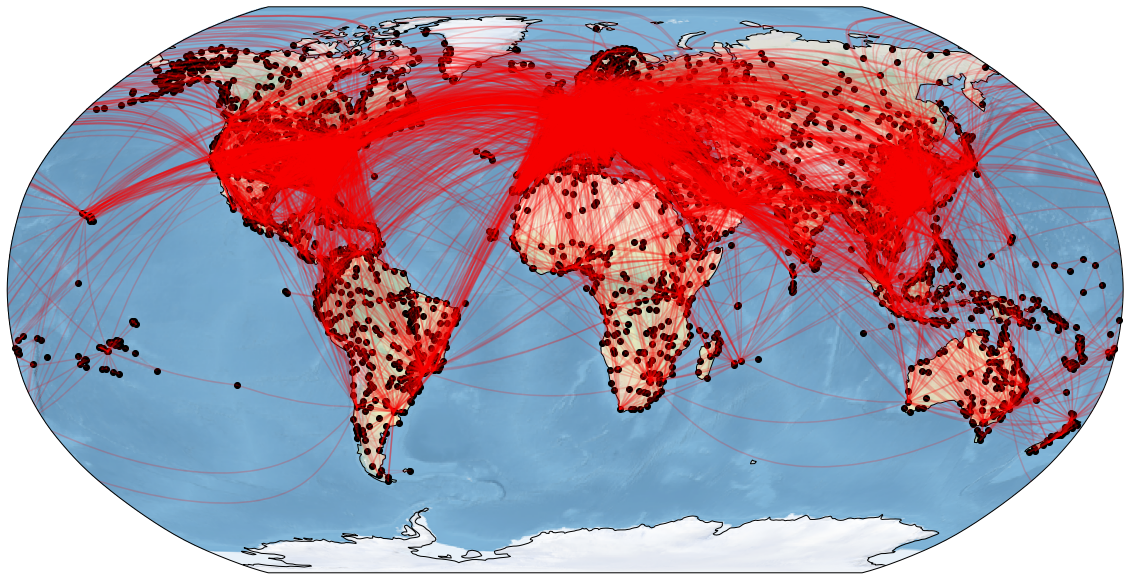

In [4]:
def plot_network_on_map(network_df, lat_lon_mapping):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

    # make the map global rather than have it zoom in to
    # the extents of any plotted data
    ax.set_global()

    ax.stock_img()
    ax.coastlines()

    for country in network_df.columns.values:
        pos = lat_lon_mapping[country]
        ax.plot(pos['lon'], pos['lat'], 'o', transform=ccrs.PlateCarree(), c='k')
    
    n = network_df.shape[0]
    for i in range(n):
        for j in range(n):
            source_pos = lat_lon_mapping[network_df.index[i]]

            if network_df.iloc[i,j] != 0:
                dest_pos = lat_lon_mapping[network_df.columns[j]]
                ax.plot([source_pos['lon'], dest_pos['lon']], [source_pos['lat'], dest_pos['lat']], transform=ccrs.Geodetic(), c='r', alpha=0.1)

    plt.show()
    
plot_network_on_map(airport_routes_matrix, lat_lon_mapping_IATA_airport)

### Compute network summary statistics

Number of Nodes: 3272 Number of Edges: 36958
--- In Degree --


node  in_degree country
919    919        237     FRA
55      55        232     CDG
471    471        230     AMS
2594  2594        229     IST
2880  2880        215     ATL
79      79        205     PEK
1020  1020        203     ORD
254    254        189     DME
1066  1066        188     MUC
1764  1764        185     DFW

--- Out Degree --


node  out_degree country
919    919         238     FRA
55      55         236     CDG
471    471         231     AMS
2594  2594         226     IST
2880  2880         216     ATL
1020  1020         206     ORD
79      79         205     PEK
1066  1066         190     MUC
254    254         189     DME
1764  1764         187     DFW

--- Eigenvector Centrality --


node  eigenvector_centrality country
0   919                0.165863     FRA
1   471                0.165786     AMS
2    55                0.159223     CDG
3  1066                0.148761     MUC
4   147                0.137041     LHR
5  3153                0.136459     FCO
6  2594                0.130208     IST
7    72                0.129656     BCN
8  2228                0.126720     ZRH
9     5                0.123699     MAD

--- PageRank --


node  page_rank country
0  2880   0.004825     ATL
1  2594   0.004577     IST
2  1020   0.004460     ORD
3  1507   0.004432     DEN
4  1764   0.004352     DFW
5   254   0.004296     DME
6    55   0.004116     CDG
7   919   0.003997     FRA
8    79   0.003979     PEK
9   471   0.003790     AMS

--- Betweeness --


node  betweeness country
0    55    0.063151     CDG
1  3035    0.060666     LAX
2  3199    0.058978     DXB
3  2555    0.054430     ANC
4   919    0.052044     FRA
5    79    0.050076     PEK
6  1020    0.045056     ORD
7   471    0.043831     AMS
8   698    0.043557     YYZ
9  2594    0.042733     IST

--- Edge Betweeness --


source  destination  edge_betweeness source_country destination_country
28396    2555         3035         0.007921            ANC                 LAX
34145    3035         2555         0.007915            LAX                 ANC
11710    1020         2555         0.006892            ORD                 ANC
28373    2555         1020         0.006891            ANC                 ORD
27922    2483         2555         0.006420            BET                 ANC
28390    2555         2483         0.006413            ANC                 BET
31137    2820          698         0.005851            YQT                 YYZ
30938    2810          396         0.005773            SEA                 FAI
4700      396         2810         0.005599            FAI                 SEA
8382      698         2820         0.005541            YYZ                 YQT

--- Coreness --


node  coreness country
0  3153        62     FCO
1    72        62     BCN
2  2411        62     MAN
3   471        62     AMS
4   243        62     AYT
5  1904        62     CGN
6  2689        62     ATH
7   190        62     HAM
8  2692        62     SOF
9   919        62     FRA

--- Hubs --


node       hub country
0   162  0.019903     QOW
1   199  0.019504     MKG
2   211  0.019379     MZG
3   127  0.018692     LUO
4   196  0.017821     MMB
5   189  0.017701     SVQ
6     1  0.017408     PRA
7    53  0.016095     SHM
8   206  0.015522     ELU
9   130  0.015336     JUL

--- Authorities --


node  authority country
0   162   0.019841     QOW
1   199   0.019651     MKG
2   211   0.019413     MZG
3   127   0.019066     LUO
4   189   0.017776     SVQ
5   196   0.017666     MMB
6     1   0.017521     PRA
7    53   0.016102     SHM
8   130   0.015351     JUL
9   206   0.015274     ELU

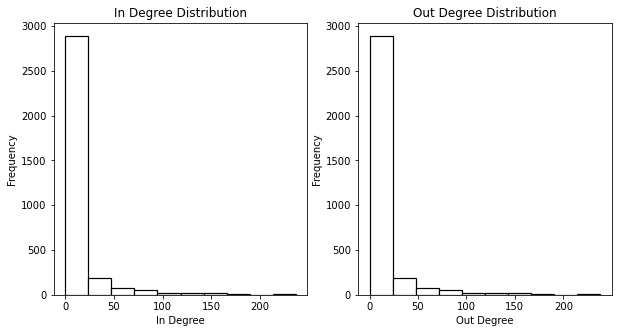

In [115]:
def summary_stats(routes_matrix):
    G = nx.from_numpy_matrix(routes_matrix.values,create_using=nx.DiGraph())
    
    # Node / Edge Counts
    print("Number of Nodes: %s Number of Edges: %s" % (G.number_of_nodes(), G.number_of_edges()))
    
    plt.figure(figsize=(10,5))
    grid = (1,2)
    
    ax_1 = plt.subplot2grid(grid, (0,0))
    ax_2 = plt.subplot2grid(grid, (0,1))
    
    # Degree Measurements
    ax_1.set_title('In Degree Distribution')
    ax_1.set_xlabel('In Degree')
    ax_2.set_title('Out Degree Distribution')
    ax_2.set_xlabel('Out Degree')
    
    in_degree = pd.DataFrame(G.in_degree, columns=['node','in_degree']).sort_values(by='in_degree', ascending=False)
    out_degree = pd.DataFrame(G.out_degree, columns=['node','out_degree']).sort_values(by='out_degree', ascending=False)
    in_degree['country'] = in_degree['node'].apply(lambda i: routes_matrix.index[i])
    out_degree['country'] = in_degree['node'].apply(lambda i: routes_matrix.index[i])
    
    in_degree['in_degree'].plot(kind='hist', ax=ax_1, color='white', edgecolor='k', linewidth=1.2)
    out_degree['out_degree'].plot(kind='hist', ax=ax_2, color='white', edgecolor='k', linewidth=1.2)
    
    print('--- In Degree --')
    display(in_degree.head(10))
    print('--- Out Degree --')
    display(out_degree.head(10))
    
    def process_node_stat(G, stat_fn, stat_name, edge=False):
        if not edge:
            stat_df = pd.DataFrame.from_records({key: [value] for key,value in stat_fn(G).items()}).T.sort_values(by=0, ascending=False)
            stat_df = stat_df.reset_index()
            stat_df.columns = ['node',stat_name]
            stat_df['country'] = stat_df['node'].apply(lambda i: routes_matrix.index[i])
        else:
            stat_df = pd.DataFrame.from_records([{'source': key[0], 'destination': key[1], 'value':value} for key,value in stat_fn(G).items()])
            stat_df = stat_df.sort_values(by='value', ascending=False)
            stat_df.columns = ['source', 'destination', stat_name]
            stat_df['source_country'] = stat_df['source'].apply(lambda i: routes_matrix.index[i])
            stat_df['destination_country'] = stat_df['destination'].apply(lambda i: routes_matrix.index[i])
        
        return stat_df
    
    # Eigenvector Centrality / Page Rank / Betweeness
    eig = process_node_stat(G, nx.eigenvector_centrality, 'eigenvector_centrality')
    pr = process_node_stat(G, nx.pagerank, 'page_rank')
    betweenness = process_node_stat(G, nx.betweenness_centrality, 'betweeness')
    edge_betweenness = process_node_stat(G, nx.edge_betweenness_centrality, 'edge_betweeness', edge=True)
    coreness = process_node_stat(G, nx.core_number, 'coreness')
    
    print('--- Eigenvector Centrality --')
    display(eig.head(10))
    
    print('--- PageRank --')
    display(pr.head(10))
    
    print('--- Betweeness --')
    display(betweenness.head(10))
    
    print('--- Edge Betweeness --')
    display(edge_betweenness.head(10))
    
    print('--- Coreness --')
    display(coreness.head(10))

    # Hub Authority Centrality
    hits_dict = nx.hits(Y)
    
    def format_hits(hits_dict, stat_name='hub'):
        stat_df = pd.DataFrame.from_records({key: [value] for key,value in hits_dict.items()}).T.sort_values(by=0, ascending=False)
        stat_df = stat_df.reset_index()
        stat_df.columns = ['node',stat_name]
        stat_df['country'] = stat_df['node'].apply(lambda i: routes_matrix.index[i])
        
        return stat_df

    hubs = format_hits(hits_dict[0], 'hub')
    authorities = format_hits(hits_dict[1], 'authority')
    
    print('--- Hubs --')
    display(hubs.head(10))
    
    print('--- Authorities --')
    display(authorities.head(10))
    
    plt.show()
    
    all_stats = eig.set_index('node').join([df.set_index('node').drop(columns='country') for df in [pr,betweenness, coreness, authorities, hubs, in_degree, out_degree]])
    
    return all_stats, edge_betweenness
    
# stats_countries = summary_stats(country_routes_matrix)
stats_airports = summary_stats(airport_routes_matrix)
stats_airports[0].columns = [col if col != 'country' else 'airport' for col in stats_airports[0].columns]

#### Degree Distribution Comparison

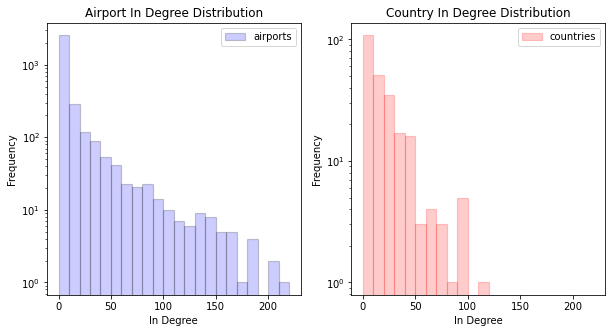

In [12]:
plt.figure(figsize=(10,5))
grid = (1,2)

ax_1 = plt.subplot2grid(grid, (0,0))
ax_2 = plt.subplot2grid(grid, (0,1))

# Degree Measurements
ax_1.set_title('Airport In Degree Distribution')
ax_1.set_xlabel('In Degree')
ax_2.set_title('Country In Degree Distribution')
ax_2.set_xlabel('In Degree')

in_degree_airport = pd.DataFrame(Z.in_degree, columns=['node','in_degree']).sort_values(by='in_degree', ascending=False)
in_degree_country = pd.DataFrame(Y.in_degree, columns=['node','in_degree']).sort_values(by='in_degree', ascending=False)
in_degree_airport['country'] = in_degree_airport['node'].apply(lambda i: airport_routes_matrix.index[i])
in_degree_country['country'] = in_degree_country['node'].apply(lambda i: country_routes_matrix.index[i])

in_degree_airport['in_degree'].plot(kind='hist', ax=ax_1, color='b', edgecolor='k', linewidth=1.2, bins=22, range=(0,220), alpha=0.2, label='airports')
in_degree_country['in_degree'].plot(kind='hist', ax=ax_2, color='r', edgecolor='r', linewidth=1.2, bins=22, range=(0,220), alpha = 0.2, label='countries')
ax_1.set_yscale('log')
ax_2.set_yscale('log')
ax_1.legend()
ax_2.legend()

#### Robsutness Checks Using Percolation Algorithm
##### Algo:
1. Start with an empty network with no occupied vertices. Let c = 0 be the number of clusters in the network initially. Choose at random an order in which the vertices will be added to the network. 
2. Add the next vertex in the chosen order, initially with no edges. This vertex is a cluster in its own right, so increase c by one and label the vertex with label c to indicate which cluster it belongs to. Also make a note that cluster c has size 1.
3. Go through the edges attached to this vertex one by one. For each edge determine whether the vertex at the other end has already been added to the network. If it has, add the edge to the network. 
4. As each edge is added, examine the cluster labels of the vertices at either end. If they are the same, do nothing. If they are different, choose one of the clusters and relabel all its vertices to have the same label as the other cluster. Update the record of the size of the cluster to be equal to the sum of the sizes of the two clusters from which it was formed. 
5. Repeat from step 2 until all vertices have been added.

In [35]:
class PercolateNetwork:
    def __init__(self, adj_matrix, method='random', ranking=None):
        """
        :params adj_matrix: A_{i,j} = 1 describes a directed edge from i -> j
        :param percolate_by_degree: If true the order in which vertices are added will be in ascending degree order
        :return S(phi): Cluster size (as proportion of the network) function of phi
        """
        self.n_verts = adj_matrix.shape[0]
        self.largest_cluster_size = [] # Record appended after each step
        self.adj_matrix = adj_matrix
        self.method = method
        
        if type(ranking) == type(None):
            self.ranking = np.zeros((adj_matrix.shape[0],1))
        else:
            self.ranking = ranking.reshape((-1,1))
        
        
    def init_percolate(self):
        self.num_clusters = 0
        self.clusters = {} # Dict of cluster id's with values lists of vertex members
        self.vertex_cluster_map = {} # Key (Vertex id) Value (Cluster Number)
        self.adj_matrix, self.ranking = shuffle(self.adj_matrix, self.ranking) # Introduce randomness to ordering over iterations safely
        
        # Choose ordering in which vertices are added
        if self.method == 'degree':
            # Sort vertices indices by ascending degree
            # Introduce randomness to order of sort for equal degrees
            # Degrees will be removed in desc order 
            self.degrees = self.adj_matrix.sum(axis=1)
            self.vertex_ordering = list(np.argsort(self.degrees))
        elif self.method == 'random':
            # Random ordering of addition
            self.vertex_ordering = list(np.arange(0,self.n_verts))
#             np.random.shuffle(self.vertex_ordering)
        elif self.method == 'ranking':
            # Custom ranking criteria (eg. PageRank)
            self.vertex_ordering = list(np.argsort(self.ranking.reshape((-1,))))
    
    def percolate(self, n_iters=1000, verbose=False):
        for iter_t in range(n_iters):
            if verbose: 
                print(iter_t)
                
            self.init_percolate()
            self.largest_cluster_size.append([]) # New iteration of cluster sizes
            
            while len(self.vertex_ordering) > 0:
                if verbose and len(self.vertex_ordering) % 200 == 0: 
                    print(len(self.vertex_ordering))
                    
                # Create a new cluster of a single vertex
                next_vert = self.vertex_ordering.pop(0)
                self.num_clusters += 1
                self.clusters[self.num_clusters] = [next_vert]
                self.vertex_cluster_map[next_vert] = self.num_clusters
                
                # Iterate over edges and add edges where the vertex already exists in the network
                vert_edges = np.nonzero(self.adj_matrix[next_vert, :])[0]
                neighbouring_verts_in_network = list(filter(lambda x: x in self.vertex_cluster_map, vert_edges))

                for other_vert in neighbouring_verts_in_network:
                    # Join clusters if different
                    vert_cluster_idx = self.vertex_cluster_map[next_vert]
                    other_cluster_idx = self.vertex_cluster_map[other_vert]

                    if vert_cluster_idx != other_cluster_idx:
                        vert_cluster = self.clusters[vert_cluster_idx] 
                        other_cluster = self.clusters[other_cluster_idx]

                        # Expand other_cluster
                        self.clusters[other_cluster_idx] = other_cluster + vert_cluster

                        # Relabel Verts
                        for relabel_vert in vert_cluster:
                            self.vertex_cluster_map[relabel_vert] = other_cluster_idx

                # Update largest cluster
                cluster_size = 0
                for cluster_idx, verts_in_cluster in self.clusters.items():
                    size = len(verts_in_cluster)

                    if size > cluster_size:
                        cluster_size = size

                self.largest_cluster_size[iter_t].append(cluster_size)
                
            if verbose:
                print('iter_finished')
                
        # Average Cluster Sizes
        avg_cluster_sizes = np.array(self.largest_cluster_size).mean(axis=0)
        normalised_avg_cluster_sizes = avg_cluster_sizes / self.n_verts
        
        # We must include the trivial zero vertices added for correct calculation
        normalised_avg_cluster_sizes = np.array([0] + list(normalised_avg_cluster_sizes))
        
        # Compute Cluster size as function of phi
        # In notation of:
        # Newman, Mark. Networks: An Introduction (Kindle Location 11509). Oxford University Press, USA. Kindle Edition. 
        
        def S(phi):
            # Edge cases
            if phi == 0:
                return 0
            if phi == 1:
                return normalised_avg_cluster_sizes[self.n_verts - 1]
            
            n = self.n_verts
            p = phi
            
            def vectorised_pmf(ks):
                ks_end = n - ks + 1

                X = np.repeat(np.arange(0,n+1).reshape(1,-1),repeats=ks.shape[0], axis=0)
                Y = np.repeat(np.arange(0,n+1).reshape(1,-1),repeats=ks.shape[0], axis=0)


                for row in range(X.shape[0]):
                    X[row,:ks[row] + 1] = 1 # When we take log this is zero
                    Y[row, ks_end[row]:] = 1

                Y[:, 0] = 1 # Fix up for log(0)

                combination_num = np.log(X).sum(axis=1)
                combination_den = np.log(Y).sum(axis=1)
                combination_log = combination_num - combination_den

                p_k_log = ks * np.log(p)
                neg_p_K_log = (n - ks) * np.log(1 - p) # (1-p)^(n-k)
                p_log = combination_log + p_k_log + neg_p_K_log
                probability = np.exp(np.maximum(p_log, np.log(10e-15))) # Prevent overflow

                return probability
            
            r = np.arange(0, normalised_avg_cluster_sizes.shape[0])
            probabilities = vectorised_pmf(r)

            s_phi = (probabilities * normalised_avg_cluster_sizes).sum()
            return s_phi
        
        return S

In [68]:
def percolate_network_by_stats(routes_matrix, route_stats, ax, network_name):
    
    pr = route_stats.sort_values(by='node')['page_rank'].values
    btw = route_stats.sort_values(by='node')['betweeness'].values
    core = route_stats.sort_values(by='node')['coreness'].values

    pc = PercolateNetwork(routes_matrix.values)
    s_phi = pc.percolate(n_iters = 100)
    print("Computing phi")
    s_values = np.array([s_phi(phi) for phi in np.linspace(0,1,100)])

    pc_degree = PercolateNetwork(routes_matrix.values, method='degree')
    s_phi_degree = pc_degree.percolate(n_iters = 100)
    print("Computing phi")
    s_values_by_degree = np.array([s_phi_degree(phi) for phi in np.linspace(0,1,100)])

    pc_pr = PercolateNetwork(routes_matrix.values, method='ranking', ranking = pr)
    s_phi_pr = pc_pr.percolate(n_iters = 100)
    print("Computing phi")
    s_values_by_pr = np.array([s_phi_pr(phi) for phi in np.linspace(0,1,100)])

    pc_bwtn = PercolateNetwork(routes_matrix.values, method='ranking', ranking = btw)
    s_phi_bwtn = pc_bwtn.percolate(n_iters = 100)
    print("Computing phi")
    s_values_by_bwtn = np.array([s_phi_bwtn(phi) for phi in np.linspace(0,1,100)])

    pc_core = PercolateNetwork(routes_matrix.values, method='ranking', ranking = core)
    s_phi_core = pc_core.percolate(n_iters = 100)
    print("Computing phi")
    s_values_by_core = np.array([s_phi_core(phi) for phi in np.linspace(0,1,100)])

    plt.figure(figsize=(8,5))

    phi = np.linspace(0,1,100)

    ax.set_title('Percolation of %s Network' % network_name)
    ax.plot(phi, s_values, c='k', label='Random')
    ax.set_xlabel('Fraction of vertices present $\phi$')
    ax.set_ylabel('Size of the largest cluster $S$')
    ax.plot(phi, s_values_by_degree, c='k', label='Degree', linestyle='--')
    ax.plot(phi, s_values_by_pr, c='b', label='PageRank', linestyle='dotted')
    ax.plot(phi, s_values_by_bwtn, c='r', label='Betweenness', linestyle='dotted')
    ax.plot(phi, s_values_by_core, c='g', label='Coreness', linestyle='dotted')
    ax.legend()

In [142]:
airport_route_stats = pd.read_csv('./outputs/airport_route_stats.csv')
country_route_stats = pd.read_csv('./outputs/country_route_stats.csv')

Computing phi
Computing phi
Computing phi
Computing phi
Computing phi
Computing phi
Computing phi
Computing phi
Computing phi
Computing phi


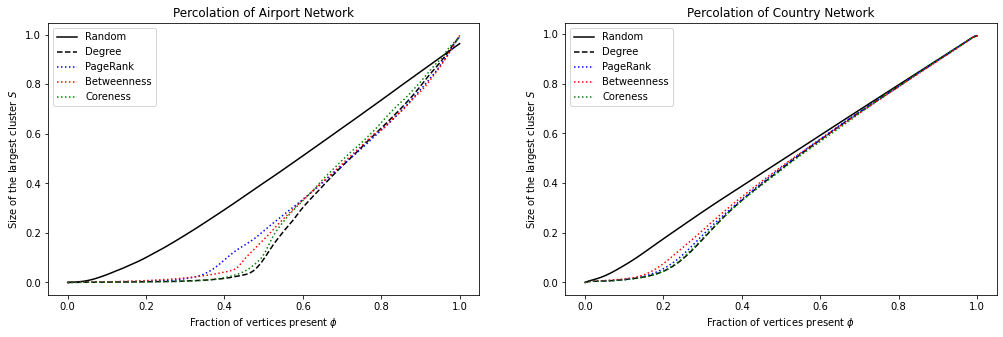

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

In [70]:
plt.figure(figsize=(17,5))
grid = (1,2)

ax_1 = plt.subplot2grid(grid, (0,0))
ax_2 = plt.subplot2grid(grid, (0,1))

# percolate_network_by_stats(airport_routes_matrix)
percolate_network_by_stats(airport_routes_matrix, airport_route_stats ,ax_1, 'Airport')
percolate_network_by_stats(country_routes_matrix, country_route_stats ,ax_2, 'Country')

#### Community Detection
We will assume an undirected graph

In [4]:
Y = nx.from_numpy_matrix(country_routes_matrix.values,create_using=nx.Graph())
Z = nx.from_numpy_matrix(airport_routes_matrix.values,create_using=nx.Graph())
airport_route_stats = pd.read_csv('./outputs/airport_route_stats.csv')
country_route_stats = pd.read_csv('./outputs/country_route_stats.csv')

In [128]:
country_communities = list(nx.algorithms.community.greedy_modularity_communities(Y))
airport_communities = list(nx.algorithms.community.greedy_modularity_communities(Z))

In [3]:
def get_n_distinct_rgb_colors(n_colors):
    cm = plt.get_cmap('gist_rainbow')
    n = min(n_colors, 120)
    
    if n_colors > 120:
        return shuffle([cm(1.*i/n) for i in range(n)]) + ['k']*(n_colors - n)
    else:
        return shuffle([cm(1.*i/n) for i in range(n)])

def prep_communities_mapping(communities, routes_matrix, route_stats):
    communities_stats = []

    colors = get_n_distinct_rgb_colors(len(communities))
    communities_color_map = {}

    for idx, c in enumerate(communities):
        nodes = list(c)

        for node in nodes:
            communities_color_map[routes_matrix.columns.values[node]] = {'idx':idx, 'color': colors[idx]}

        communities_stats.append(route_stats[route_stats['node'].isin(nodes)].sort_values(by='page_rank', ascending = False))
    
    return communities_color_map, communities_stats

In [6]:
def plot_network_communities_on_map(network_df, lat_lon_mapping, communities_color_map, plot_routes=False):
    fig = plt.figure(figsize=(50, 50))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

    # make the map global rather than have it zoom in to
    # the extents of any plotted data
    ax.set_global()

    ax.stock_img()
    ax.coastlines()

    for country in network_df.columns.values:
        
        if country in lat_lon_mapping:
            pos = lat_lon_mapping[country]
            ax.scatter(pos['lon'], pos['lat'], marker='$%s$' % communities_color_map[country]['idx'], s=100,transform=ccrs.PlateCarree(), color=communities_color_map[country]['color'])
        else:
            print("Missing lat lon key: %s" % country)
    n = network_df.shape[0]
    
    # Plots routes
    if plot_routes:
        for i in range(n):
            for j in range(n):

                if network_df.index[i] not in lat_lon_mapping:
                    continue

                source_pos = lat_lon_mapping[network_df.index[i]]

                if network_df.iloc[i,j] != 0:

                    if network_df.columns[j] not in lat_lon_mapping:
                        continue

                    dest_pos = lat_lon_mapping[network_df.columns[j]]
                    ax.plot([source_pos['lon'], dest_pos['lon']], [source_pos['lat'], dest_pos['lat']], transform=ccrs.Geodetic(), c='k', alpha=0.01)

    plt.show()
    

Missing lat lon key: GL
Missing lat lon key: PG
Missing lat lon key: MV
Missing lat lon key: ID
Missing lat lon key: VN
Missing lat lon key: UG
Missing lat lon key: SB
Missing lat lon key: VE
Missing lat lon key: NO
Missing lat lon key: CR
Missing lat lon key: EC
Missing lat lon key: CN
Missing lat lon key: US
Missing lat lon key: BR
Missing lat lon key: PF
Missing lat lon key: MY
Missing lat lon key: ZA
Missing lat lon key: ZM
Missing lat lon key: RU


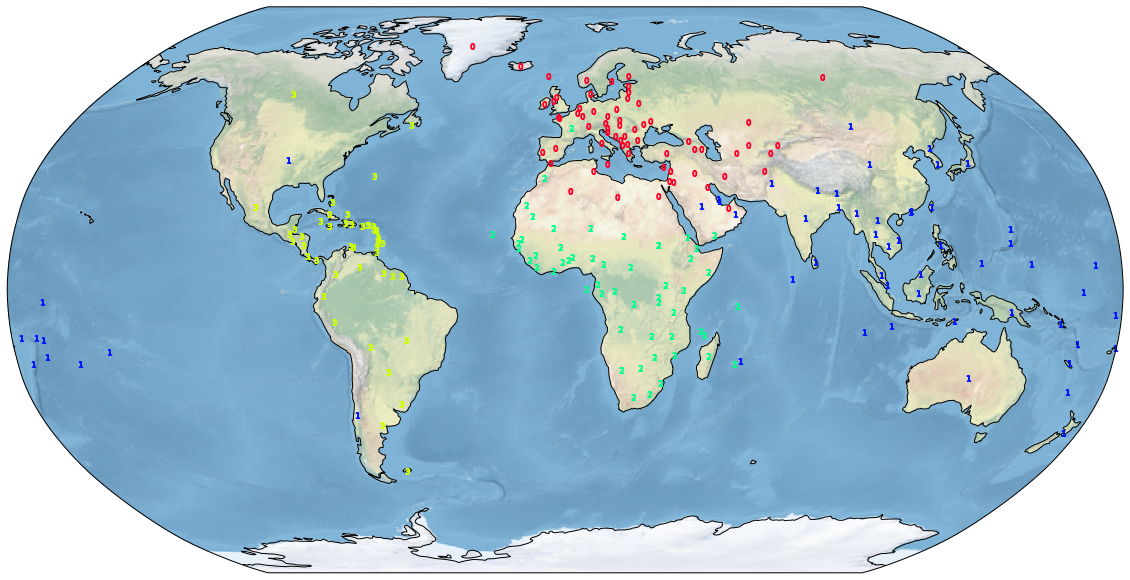

In [131]:
country_communities_color_map, country_communities_stats = prep_communities_mapping(country_communities, country_routes_matrix, country_route_stats)
plot_network_communities_on_map(country_routes_matrix, lat_lon_mapping, country_communities_color_map)

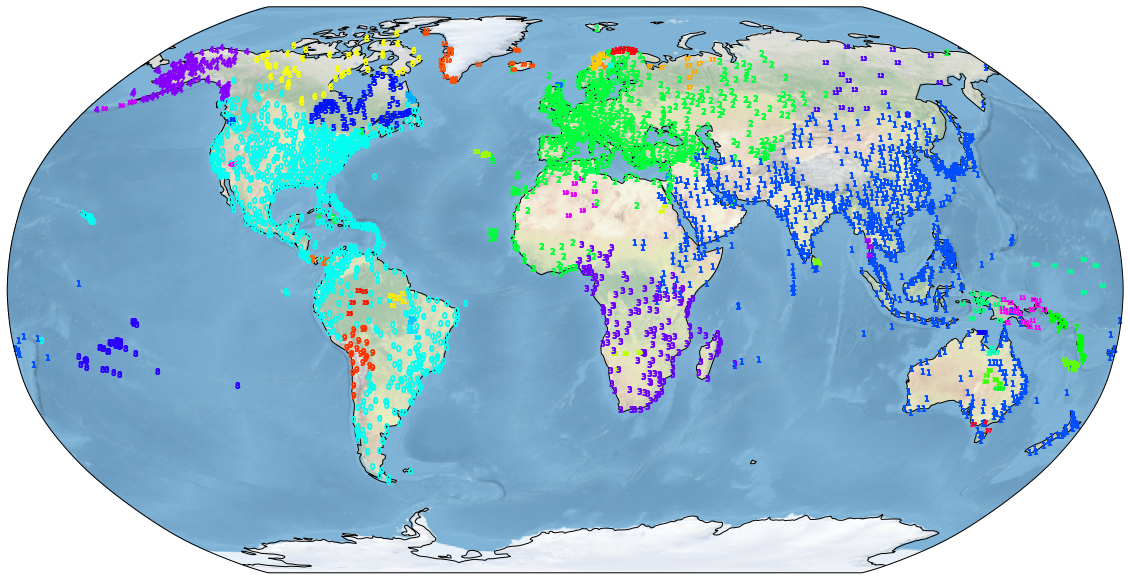

In [132]:
airport_communities_color_map, airport_communities_stats = prep_communities_mapping(airport_communities, airport_routes_matrix, airport_route_stats)
plot_network_communities_on_map(airport_routes_matrix, lat_lon_mapping_IATA_airport, airport_communities_color_map)

(-0.5, 10.5)

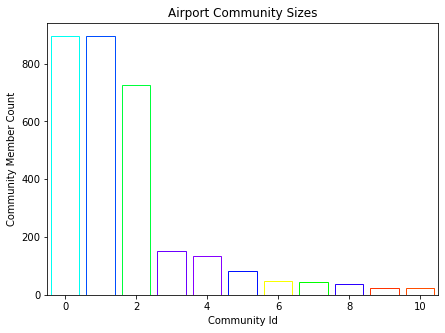

In [135]:
plt.figure(figsize=(7,5))
plt.title('Airport Community Sizes')
plt.xlabel('Community Id')
plt.ylabel('Community Member Count')

plt.bar([i for i in range(len(airport_communities))],[len(c) for c in airport_communities], color='white', linewidth=1, edgecolor=[airport_communities_color_map[airport_routes_matrix.columns.values[list(c)[0]]]['color'] for c in airport_communities])
plt.xlim(-0.5,10.5)

#### Population Data

In [2]:
from linecache import getline
from tqdm import tqdm 

source = "./datasets/gpw-v4-population-count-rev11_2020_30_min_asc/gpw_v4_population_count_rev11_2020_30_min.asc"

hdr = [getline(source, i) for i in range(1,7)]
values = [float(h.split(" ")[-1].strip()) \
 for h in hdr]
cols,rows,lx,ly,cell,nd = values
xres = cell
yres = cell

# Assemble tiles
population_grid = np.loadtxt(source, skiprows=6)
population_grid[population_grid <= 0] = 0

populated_grid_indices = np.argwhere(population_grid > 0)

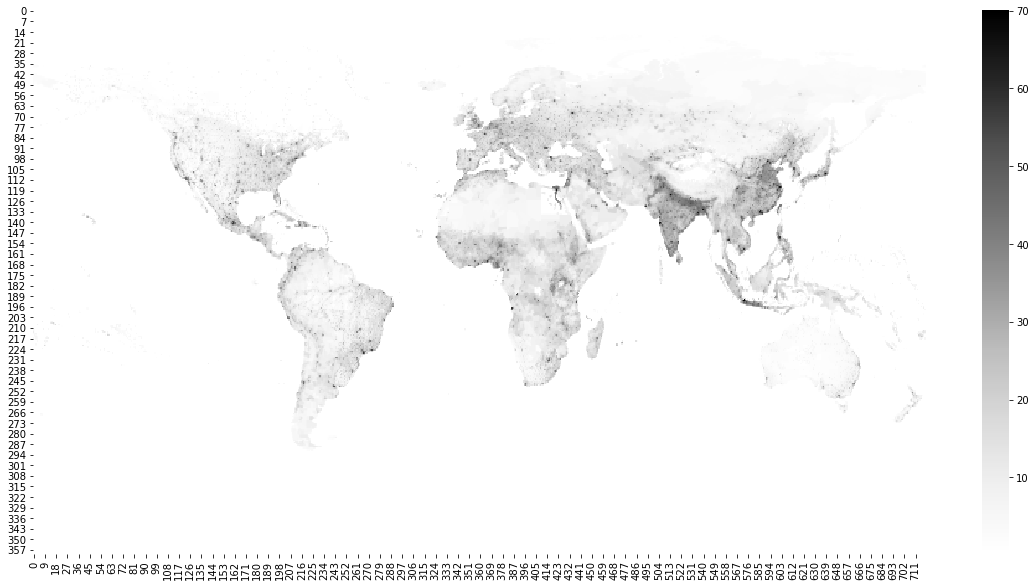

In [9]:
plt.figure(figsize=(20,10))
population_grid[population_grid <= 0] = 0
ax = sns.heatmap(np.power(population_grid + 0.001, 1/4), cmap='Greys')
plt.show()

#### Nearest Neighbour Population Assignment

In [42]:
from tqdm import tqdm

In [ ]:
def map_idx_to_lat_lon(row,col):
    return {'lat':cell*((180/cell) - row) + ly,'lon': cell * col + lx}

def compute_sq_distance(airport_ll, grid_cell_ll):
    return (airport_ll['lat'] - grid_cell_ll['lat']) ** 2 +( airport_ll['lon'] - grid_cell_ll['lon']) **2


airport_populations = {}
with tqdm(total=population_grid.shape[0] * population_grid.shape[1]) as pbar:
    for row in range(population_grid.shape[0]):
        for col in range(population_grid.shape[1]):
            grid_cell_ll = map_idx_to_lat_lon(row, col)

            distances = np.array([compute_sq_distance({'lat': lat, 'lon': lon}, grid_cell_ll) 
             for lat, lon in airports[['latitude','longitude']].values])

            min_idx = np.argmin(distances)
            closest_airport = airports['IATA'].values[min_idx]   

            if closest_airport in airport_populations:
                airport_populations[closest_airport] += population_grid[row, col]
            else:
                airport_populations[closest_airport] = population_grid[row, col]
                
            pbar.update(1)

In [ ]:
pickle.dump(airport_populations, open("./outputs/airport_populations.p", "wb" ))
# airport_populations = pickle.load(open("./outputs/airport_populations.p", 'rb'))

In [23]:
airport_populations_df = pd.Series(airport_populations).sort_values(ascending=False).reset_index()
airport_populations_df.columns = ['IATA','population']
airports_w_population = airports.merge(airport_populations_df, on='IATA')
airports_w_population.sort_values(by='population', ascending=False).head(50)

#### Compute Airport Distance Matrix & Proximity

In [17]:
airport_locations = airports_with_routes[['latitude','longitude']]

if True:
    # Precomputed values
    airport_distance_matrix = pickle.load(open('./outputs/airport_distance_matrix.p','rb'))
else: 
    dist = DistanceMetric.get_metric('haversine')
    kms = 6367
    airport_distance_matrix = kms * dist.pairwise(airport_locations.values)
    mask = np.zeros_like(airport_distance_matrix, dtype=np.bool)
    mask[np.tril_indices_from(mask)] = True
    airport_distance_matrix[~mask] = 0
    pickle.dump(airport_distance_matrix, open('./outputs/airport_distance_matrix.p','wb'))

In [137]:
plt.hist(airport_distance_matrix.ravel()[(airport_distance_matrix.ravel()>0) &(airport_distance_matrix.ravel()<300)],cumulative=True, color='white', edgecolor='black')
plt.xlabel('Radial Distance (km)')
plt.ylabel('Airports in Radius')
plt.title('Cumulative #Airports Within A Radius')

In [30]:
airports_with_routes
airport_distance_df = pd.DataFrame(airport_distance_matrix)
airport_distance_df.columns = airports_with_routes['IATA']
airport_distance_df.index = airports_with_routes['IATA']

In [34]:
airport_distance_df

IATA           GKA           MAG           HGU           LAE           POM  \
IATA                                                                         
GKA       0.000000      0.000000      0.000000      0.000000      0.000000   
MAG    5863.255065      0.000000      0.000000      0.000000      0.000000   
HGU    6738.802360   7234.476714      0.000000      0.000000      0.000000   
LAE    8952.937054   9868.315208  15663.672041      0.000000      0.000000   
POM    8373.281105  10318.283430   3090.030912  16465.541992      0.000000   
...            ...           ...           ...           ...           ...   
THD   10778.677034   6216.439666   6116.611718  14763.979990   7928.920006   
KBU    5970.108110   8476.768688   2116.258154  14635.261555   2442.773980   
MJU   12531.084866  12939.150421  19031.731686   3772.678358  16526.381369   
TGC    5188.342134    722.001266   7263.920139   9499.570394  10303.892393   
NTG    4994.630416   2965.186232   9377.244959   7042.152623  12212.686365   

IATA           WWK           UAK           GOH           SFJ           THU  \
IATA                                                                         
GKA       0.000000      0.000000      0.000000      0.000000      0.000000   
MAG       0.000000      0.000000      0.000000      0.000000      0.000000   
HGU       0.000000      0.000000      0.000000      0.000000      0.000000   
LAE       0.000000      0.000000      0.000000      0.000000      0.000000   
POM       0.000000      0.000000      0.000000      0.000000      0.000000   
...            ...           ...           ...           ...           ...   
THD   10135.416938  17336.608170   1959.087925  17200.350754   4626.672696   
KBU   13907.717760  11099.071623   8739.342968  14086.195400   6603.510954   
MJU    7049.911830   6171.187760  14131.768818   3088.303309  15311.483328   
TGC    5843.785657  15553.760329   5092.738298  14699.330239   2778.333772   
NTG    4010.950714  13533.721517   7169.410338  12226.197332   5252.676589   

IATA  ...           CCS           CBS           OHH           GRV  \
IATA  ...                                                           
GKA   ...      0.000000      0.000000      0.000000      0.000000   
MAG   ...      0.000000      0.000000      0.000000      0.000000   
HGU   ...      0.000000      0.000000      0.000000      0.000000   
LAE   ...      0.000000      0.000000      0.000000      0.000000   
POM   ...      0.000000      0.000000      0.000000      0.000000   
...   ...           ...           ...           ...           ...   
THD   ...  14283.743270  16888.716382  13875.934343  17067.343259   
KBU   ...   9484.864183   8685.010766  10244.927237  11699.991812   
MJU   ...   8489.834693   8277.067021   8031.260156   5670.517191   
TGC   ...  17104.725322  12017.832380   7005.053744  10244.668162   
NTG   ...  16174.409312  10595.317321   4910.030281   7983.687996   

IATA           FVM           THD           KBU           MJU          TGC  NTG  
IATA                                                                            
GKA       0.000000      0.000000      0.000000      0.000000     0.000000  0.0  
MAG       0.000000      0.000000      0.000000      0.000000     0.000000  0.0  
HGU       0.000000      0.000000      0.000000      0.000000     0.000000  0.0  
LAE       0.000000      0.000000      0.000000      0.000000     0.000000  0.0  
POM       0.000000      0.000000      0.000000      0.000000     0.000000  0.0  
...            ...           ...           ...           ...          ...  ...  
THD    9232.616456      0.000000      0.000000      0.000000     0.000000  0.0  
KBU   12218.497157   8217.660745      0.000000      0.000000     0.000000  0.0  
MJU    8732.301154  14827.801610  16959.523906      0.000000     0.000000  0.0  
TGC   15825.227473   6871.006878   8293.019097  12789.890864     0.000000  0.0  
NTG   16801.506439   9083.878345   9901.093890  10499.612501  2475.452062  0.0  

[3272 rows x 3272 

#### Compute Grid to Airport Distance Matrix

In [139]:
from geoindex import GeoGridIndex, GeoPoint
import random

def map_idx_to_lat_lon(row,col):
    return {'lat':(cell*((180/cell) - row) + ly) * 0.9999999,'lon': (cell * col + lx) * 0.9999999}

if False:
    # Add all the airports coords
    lat_lon_to_airport = {}
    index = GeoGridIndex(precision=1)
    for IATA, lat, lon in airports_with_routes[['IATA','latitude','longitude']].values:
        index.add_point(GeoPoint(lat, lon))
        lat_lon_to_airport['(%s,%s)' % (lat, lon)] = IATA

    # Get centralities
    airport_route_stats = pd.read_csv('./outputs/airport_route_stats.csv')
    iata_to_centrality = {row[0]:row[1] for row in airport_route_stats[['airport','page_rank']].values}    

    airport_populations = {}
    with tqdm(total=populated_grid_indices.shape[0]) as pbar:
        for row, col in populated_grid_indices:
                grid_cell_ll = map_idx_to_lat_lon(row, col)
                center_point = GeoPoint(grid_cell_ll['lat'], grid_cell_ll['lon'])
                cell_population = population_grid[row, col]

                nearby_airports = []
                for point, distance in index.get_nearest_points(center_point, 240, 'km'):
    #                 print("We found {0} in {1} km".format(point, distance))
                    nearby_airports.append(lat_lon_to_airport['(%s,%s)' % (point.latitude, point.longitude)])

                total_centrality = sum([iata_to_centrality[airport_iata] for airport_iata in nearby_airports])

                for airport_iata in nearby_airports:
                    # assign cell population to airports in proportion to their relative centralities
                    cell_population_contribution = cell_population * (iata_to_centrality[airport_iata]/total_centrality)

                    if airport_iata in airport_populations:
                        airport_populations[airport_iata] += cell_population_contribution
                    else:
                        airport_populations[airport_iata] = cell_population_contribution

                pbar.update(1)
                
    pickle.dump(airport_populations, open('./outputs/airport_populations.p','wb'))
else:
    airport_populations = pickle.load(open('./outputs/airport_populations.p','rb'))

100%|██████████| 61295/61295 [13:26<00:00, 76.03it/s] 


In [163]:
airport_populations_df = pd.Series(airport_populations).sort_values(ascending=False).reset_index()
airport_populations_df.columns = ['IATA','population']
airports_w_population = airports_with_routes.merge(airport_populations_df, on='IATA')
airports_w_population = airports_w_population.sort_values(by='population', ascending=False)
airports_w_population.to_csv('./outputs/airports_w_populations.csv')

#### Interpreting SBM Results

In [6]:
import graph_tool.all as gt
import numpy as np

def to_graph(adj):
    g = gt.Graph(directed=True)
    g.add_edge_list(np.transpose(adj.nonzero()))
    return g

/Users/hugo/anaconda3/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:1494: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [7]:
g_airport = to_graph(airport_routes_matrix.values)
state = gt.minimize_blockmodel_dl(g_airport)

b = state.get_blocks()
e = state.get_matrix()

community_labels = [[] for i in range(0,e.shape[0])]
for node, community in enumerate(b.get_array()):
    community_labels[community].append(node)

In [48]:
reindex_communities = []
ax_line_idxs = [0]
for c in community_labels:
    reindex_communities += c
    ax_line_idxs.append(ax_line_idxs[-1] + len(c))

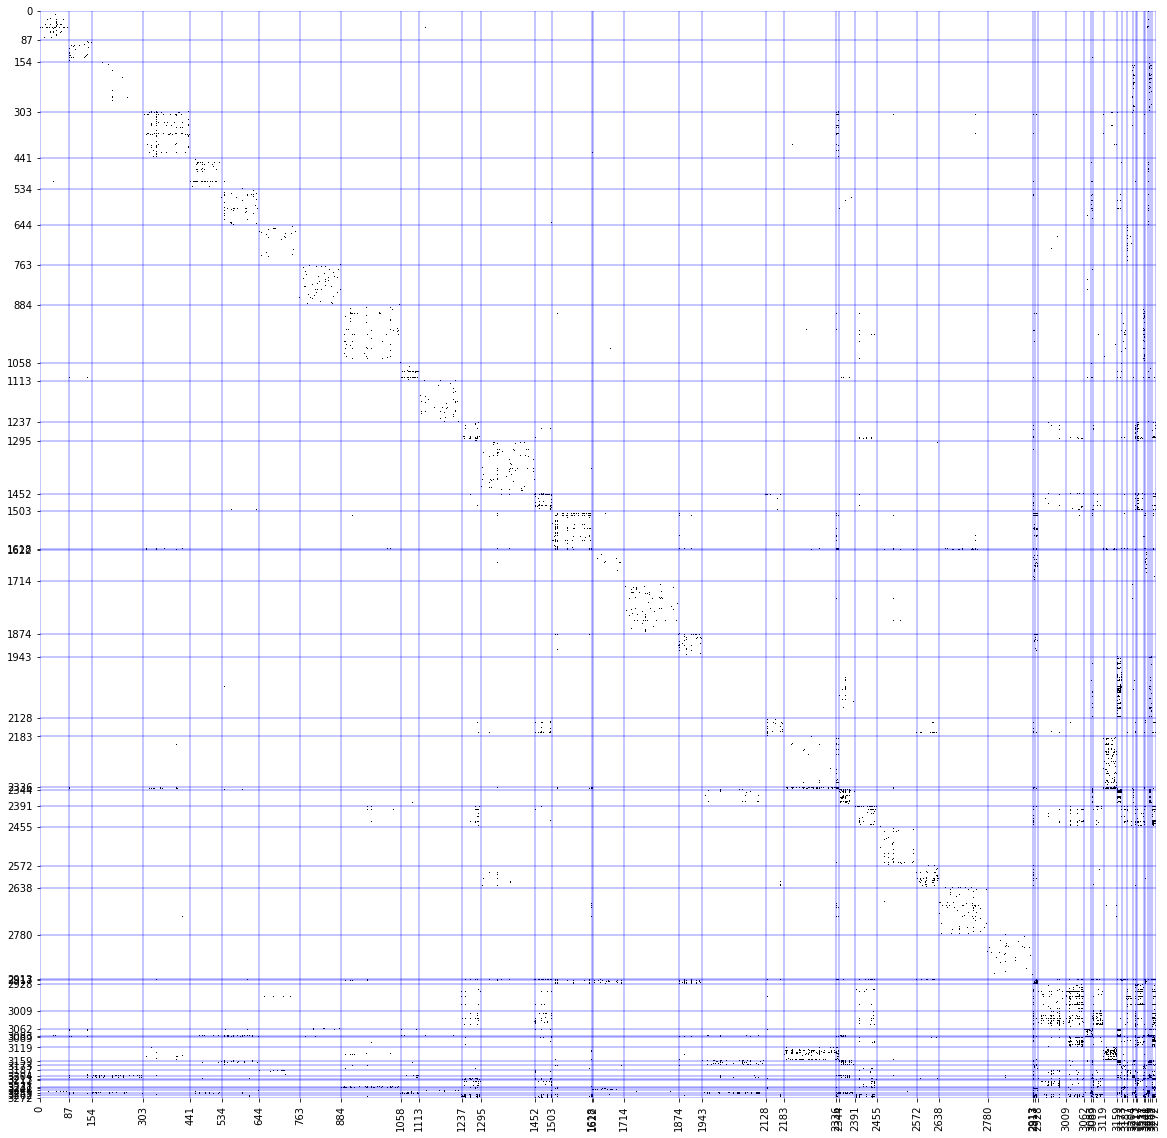

In [67]:
plt.figure(figsize=(20,20))
sns.heatmap(airport_routes_matrix.iloc[reindex_communities,].iloc[:,reindex_communities].values, cmap='binary', cbar=False)

# plt.axhline(37, c='b')
# plt.axvline(37, c='b')

for line_idx in ax_line_idxs:
    plt.axvline(line_idx, c='b', alpha=0.3)
    plt.axhline(line_idx, c='b', alpha=0.3)
    
plt.xticks(ax_line_idxs,labels=ax_line_idxs)
plt.yticks(ax_line_idxs,labels=ax_line_idxs)
plt.show()

In [13]:
IATA_community_map = {}
for node, community in enumerate(b.get_array()):
    IATA_community_map[airport_routes_matrix.columns[node]] = [community]

In [18]:
IATA_community_map_df = pd.DataFrame(IATA_community_map).T.reset_index()
IATA_community_map_df.columns = ['IATA', 'community']
IATA_community_map_df.to_csv('./outputs/bsm_communities.csv')

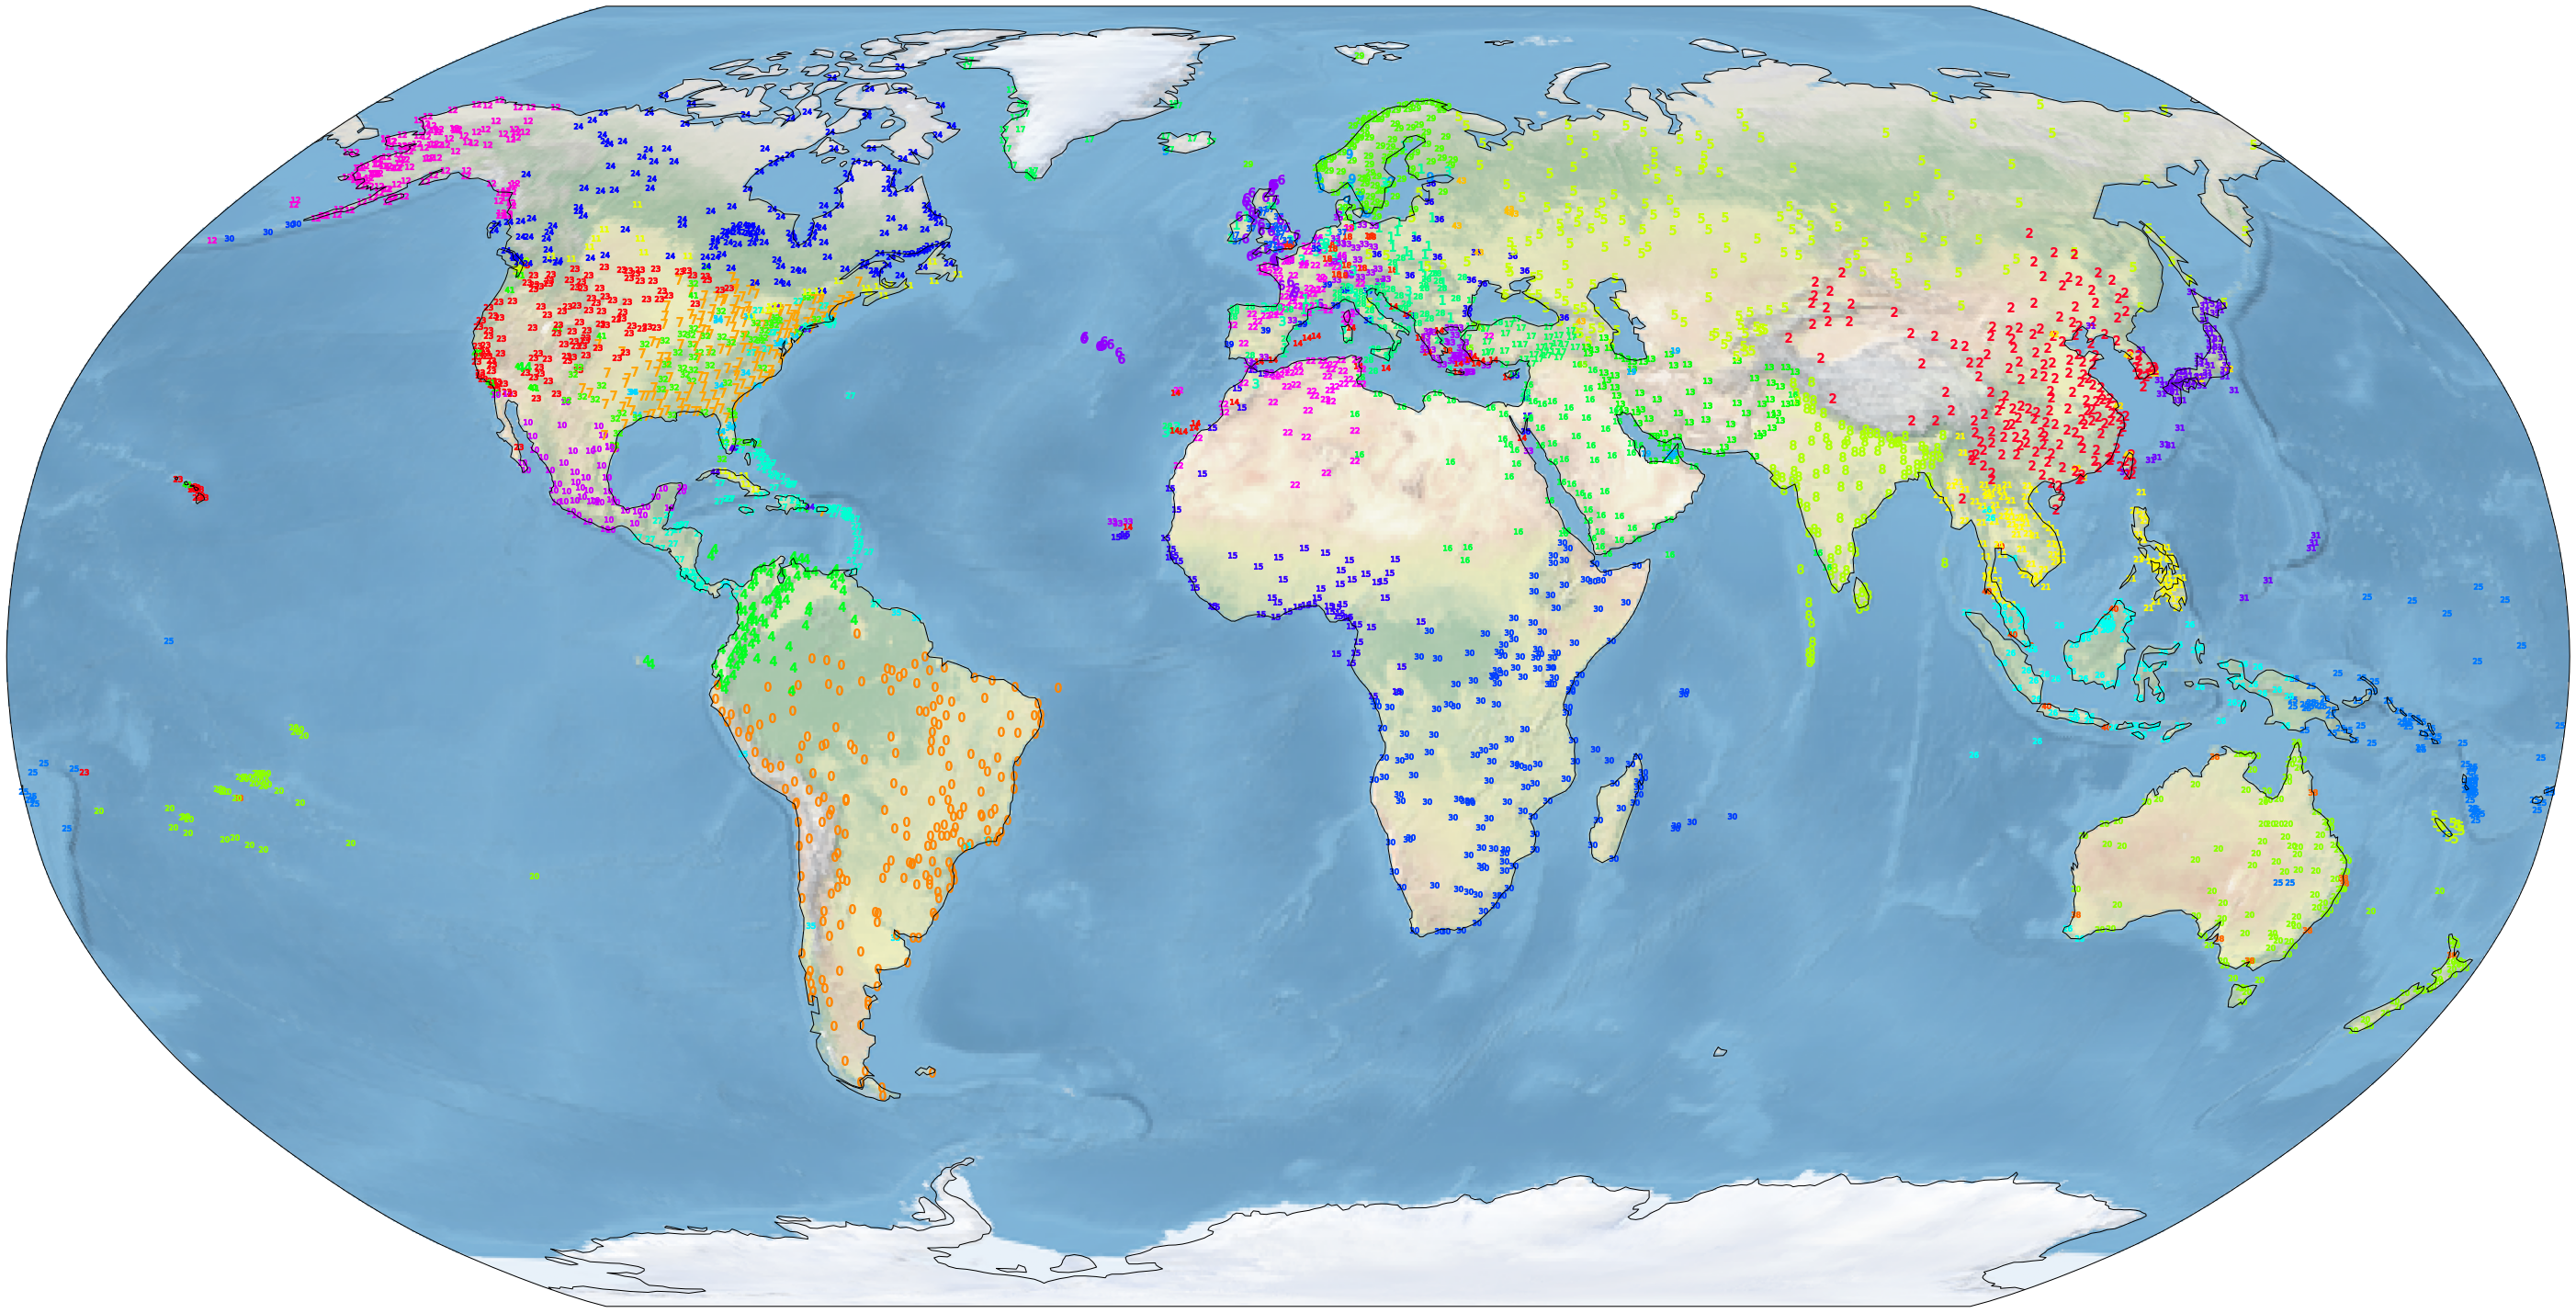

In [21]:
airport_communities_color_map, airport_communities_stats = prep_communities_mapping(community_labels, airport_routes_matrix, airport_route_stats)
plot_network_communities_on_map(airport_routes_matrix, lat_lon_mapping_IATA_airport, airport_communities_color_map)